## CNN Simple Model

Implementing a simple CNN model in order to see how it behaves and if the model learns something from the images or not.

### 00. Load libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 01. Load images
The images are separated into train, test and validation using the function of keras call image_dataset_from_directory

In [ ]:
train_dir = './labeled-images/train'
test_dir = './labeled-images/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 20

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 5752 files belonging to 8 classes.
Using 4602 files for training.
Found 5752 files belonging to 8 classes.
Using 1150 files for validation.
Found 640 files belonging to 8 classes.


### 02. Model architecture

Creation of the architecture based of state of the art.

In [ ]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(32, 3, 3, padding="same", activation='relu'))
model.add(Conv2D(32, 3, 3, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, 3, 3, padding="same", activation='relu'))
model.add(Conv2D(64, 3, 3, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(128, 3, 3, padding="same", activation='relu'))
model.add(Conv2D(128, 3, 3, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, 3, 3, padding="same", activation='relu'))
model.add(Conv2D(256, 3, 3, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(8))
model.add(Activation('softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 264, 264, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 88, 88, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 64)          36928     
                                                      

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [ ]:
cat_list = os.listdir('./labeled-images/train/')
cat_list.sort()

lenghts = [len(os.listdir('./labeled-images/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.round(1/np.array(lenghts) * total_train_images,2))

print(cat_list)
print(lenghts)
print(weights)

['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
[239, 264, 1447, 256, 115, 209, 2585, 637]
[24.07, 21.79, 3.98, 22.47, 50.02, 27.52, 2.23, 9.03]


### 04. Model train

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

The number of epochs is set to 20.

In [ ]:
model.compile(loss='categorical_crossentropy', loss_weights= weights,
            optimizer=RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // BATCH_SIZE,
    verbose=1)

Epoch 1/20
4/4 [==============================] - 70s 13s/step - loss: 52.7737 - accuracy: 0.4219 - val_loss: 45.9006 - val_accuracy: 0.4375
Epoch 2/20
4/4 [==============================] - 15s 4s/step - loss: 43.8949 - accuracy: 0.3984 - val_loss: 40.4506 - val_accuracy: 0.2500
Epoch 3/20
4/4 [==============================] - 14s 4s/step - loss: 40.5487 - accuracy: 0.3828 - val_loss: 37.3472 - val_accuracy: 0.5312
Epoch 4/20
4/4 [==============================] - 13s 4s/step - loss: 39.2016 - accuracy: 0.4531 - val_loss: 38.4089 - val_accuracy: 0.4688
Epoch 5/20
4/4 [==============================] - 12s 3s/step - loss: 41.8492 - accuracy: 0.3750 - val_loss: 39.0598 - val_accuracy: 0.5625
Epoch 6/20
4/4 [==============================] - 14s 4s/step - loss: 40.9635 - accuracy: 0.3906 - val_loss: 36.7793 - val_accuracy: 0.4062
Epoch 7/20
4/4 [==============================] - 13s 4s/step - loss: 37.7451 - accuracy: 0.4453 - val_loss: 37.4957 - val_accuracy: 0.4062
Epoch 8/20
4/4 [===

### 05. Analysis of results

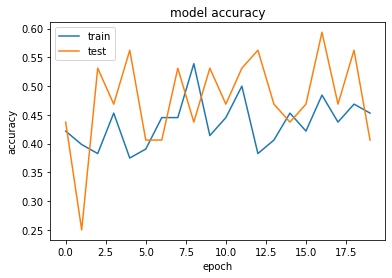

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is observed that the accuracy does not vary throughout the training and the value it takes is very low.

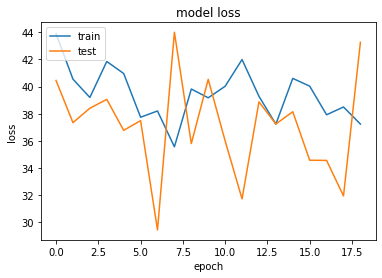

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is observed that the loss does not decrease throughout the training, so this is a sign that the model is not working correctly.

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

In [ ]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [ ]:
y_pred_class = y_pred.argmax(axis=1)

In [ ]:
y_real_class = y_real.argmax(axis=1)

Text(33.0, 0.5, 'Truth')

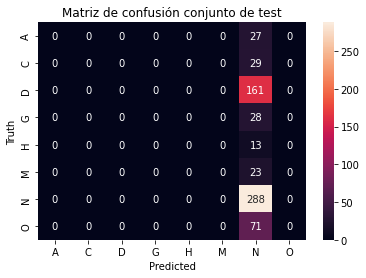

In [ ]:
labels = ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']

cf_matrix = confusion_matrix(y_real_class, y_pred_class)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Matriz de confusión conjunto de test')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_real_class, y_pred_class, target_names=labels))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        27
           C       0.00      0.00      0.00        29
           D       0.00      0.00      0.00       161
           G       0.00      0.00      0.00        28
           H       0.00      0.00      0.00        13
           M       0.00      0.00      0.00        23
           N       0.45      1.00      0.62       288
           O       0.00      0.00      0.00        71

    accuracy                           0.45       640
   macro avg       0.06      0.12      0.08       640
weighted avg       0.20      0.45      0.28       640



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The confusion matrix shows that the model classifies all the images in the normal class (N), so this indicates that the model does not know how to classify anything and is therefore invalid.